# Build an Autoencoders deep neural network model for solving any specific problems. The task and dataset you  may decide for which build a model.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import pickle
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Input,Dropout
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
%matplotlib inline

In [2]:
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=10,6
RANDOM_SEED=42
LABELS=['Normal','Fraud']

In [3]:
# Load the data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# Checking the missing values
df.isnull().values.any()

False

In [7]:
df.isna().sum().sum()

0

Text(0, 0.5, 'Frequency')

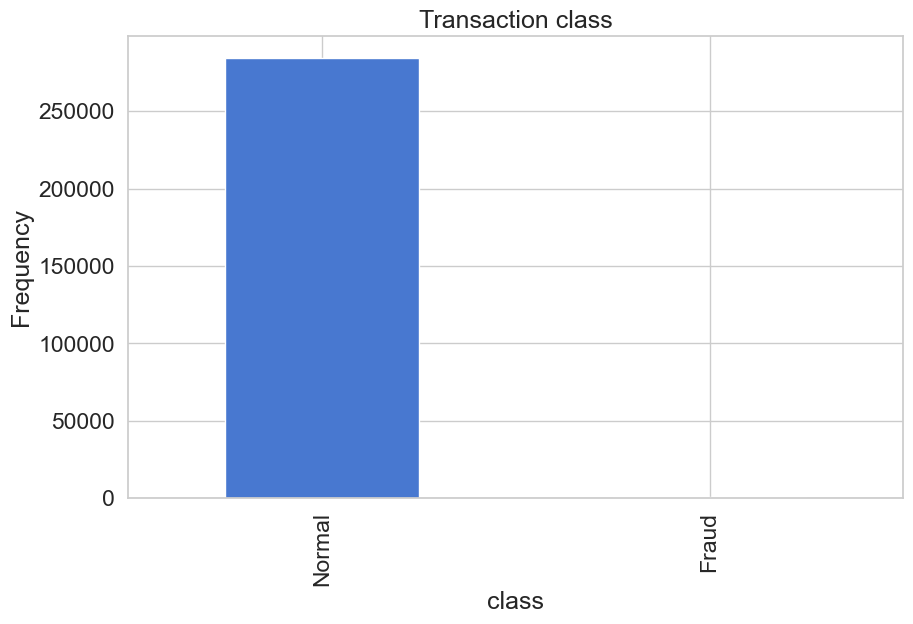

In [8]:
# Class
count_classes=pd.value_counts(df['Class'],sort=True)
count_classes.plot(kind='bar')
plt.title('Transaction class')
plt.xticks(range(2),LABELS)
plt.xlabel('class')
plt.ylabel('Frequency')

<AxesSubplot: ylabel='count'>

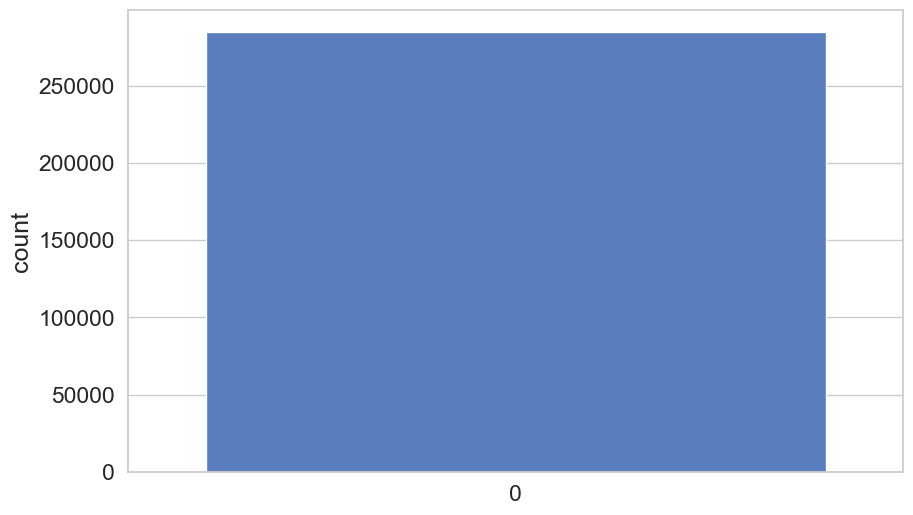

In [9]:
sns.countplot(df['Class'])

In [10]:
frauds = df[df.Class==1]
normal = df[df.Class==0]

In [11]:
frauds.shape

(492, 31)

In [12]:
normal.shape

(284315, 31)

In [13]:
# Stats info of fraudulent transaction
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
# Stats info of non-fraudulent transaction
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

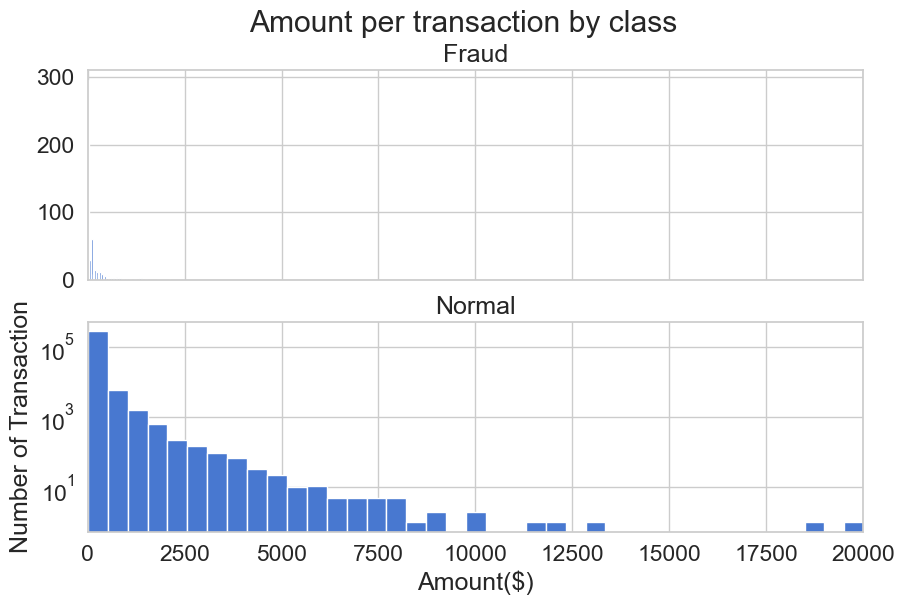

In [15]:
# Graphical representation
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
bins=50
ax1.hist(frauds.Amount,bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount,bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount($)')
plt.ylabel('Number of Transaction')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

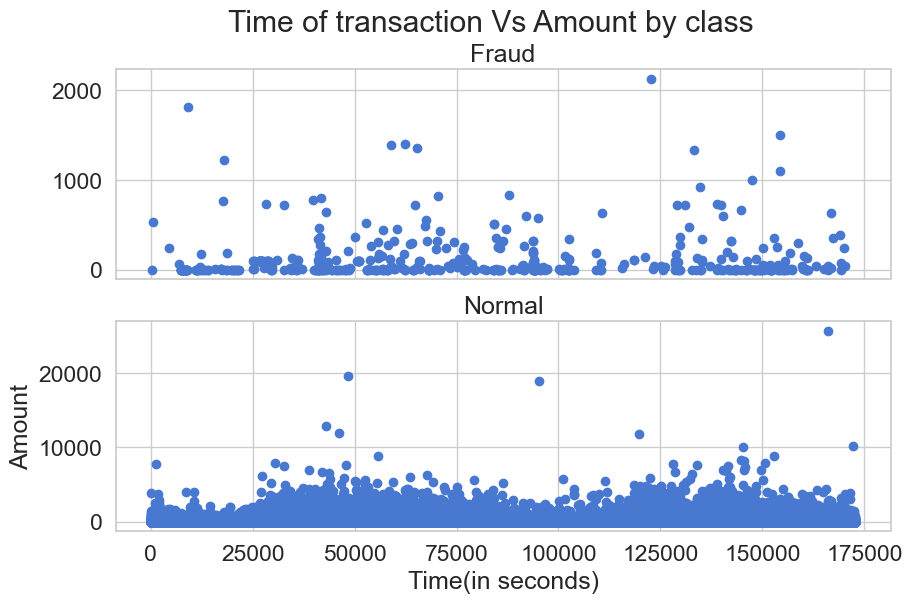

In [16]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction Vs Amount by class')
ax1.scatter(frauds.Time,frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time(in seconds)')
plt.ylabel('Amount')
plt.show()

In [17]:
# Preparing the data
from sklearn.preprocessing import StandardScaler
data=df.drop(['Time'],axis=1)
data['Amount']=StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [18]:
data['Amount'][0]

0.24496426337017338

In [19]:
# Split the data for training Autoencoder
xtrain,xtest=train_test_split(data,test_size=0.2,random_state=RANDOM_SEED)
xtrain=xtrain[xtrain.Class==0]
xtrain=xtrain.drop(['Class'],axis=1)
print(xtrain.shape)
print()

(227451, 29)



In [20]:
ytest=xtest['Class']
xtest=xtest.drop(['Class'],axis=1)
xtrain=xtrain.values
xtest=xtest.values

In [21]:
print(xtrain.shape)
print()
print(xtest.shape)

(227451, 29)

(56962, 29)


In [22]:
# Building Auto encoder model

input_dim=xtrain.shape[1]
encoding_dim=14

In [23]:
input_layer=Input(shape=(input_dim,))
encoder=Dense(encoding_dim,activation='tanh',
 activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(int(encoding_dim/2),activation='relu')(encoder)
decoder=Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)

In [24]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 14)                420       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 29)                232       
                                                                 
Total params: 813 (3.18 KB)
Trainable params: 813 (3.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Train the model

nb_epoch=30
batch_size=32

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer=ModelCheckpoint(filepath='model_ae.h5', verbose=0, save_best_only=True)

tensorboard=TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history=autoencoder.fit(xtrain,xtrain, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(xtest,xtest),
 verbose=1, callbacks=[checkpointer,tensorboard]).history


Epoch 1/30

7108/7108 [==============================] - 30s 4ms/step - loss: 0.8152 - accuracy: 0.5777 - val_loss: 0.7827 - val_accuracy: 0.6766
Epoch 2/30
  30/7108 [..............................] - ETA: 25s - loss: 0.7129 - accuracy: 0.6573

C:\Users\Ramesh\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 28s 4ms/step - loss: 0.7345 - accuracy: 0.6967 - val_loss: 0.7605 - val_accuracy: 0.6986
Epoch 3/30
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7239 - accuracy: 0.7016 - val_loss: 0.7558 - val_accuracy: 0.7013
Epoch 4/30
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7190 - accuracy: 0.7045 - val_loss: 0.7511 - val_accuracy: 0.7019
Epoch 5/30
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7161 - accuracy: 0.7061 - val_loss: 0.7485 - val_accuracy: 0.7006
Epoch 6/30
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7137 - accuracy: 0.7068 - val_loss: 0.7456 - val_accuracy: 0.7101
Epoch 7/30
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7111 - accuracy: 0.7099 - val_loss: 0.7441 - val_accuracy: 0.7091
Epoch 8/30
7108/7108 [==============================] - 27s 4ms/step - loss: 0.7092 - accuracy: 0.7103 - val_loss: 0.7434 - val_accuracy: 0.7

In [26]:
from keras.models import load_model

autoencoder=load_model('model_ae.h5')

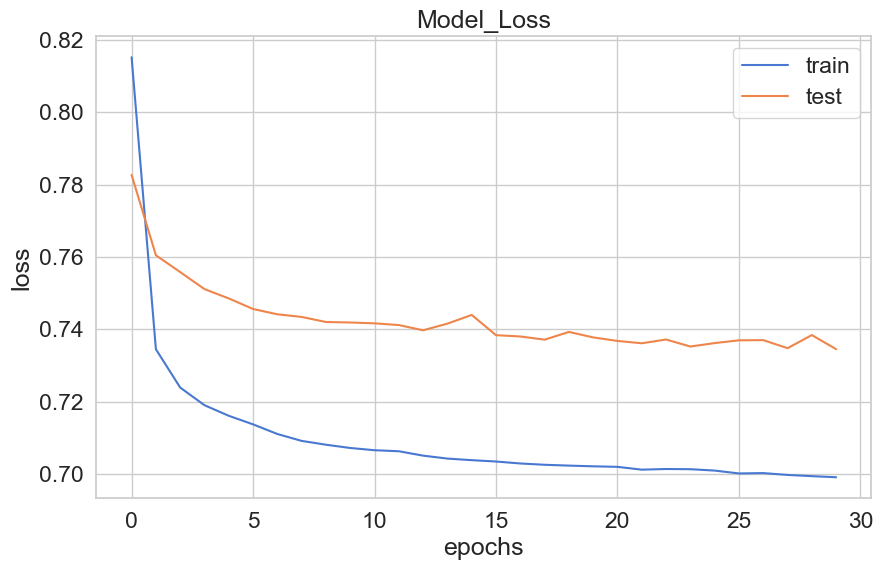

In [27]:
# Evaluation

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper right')

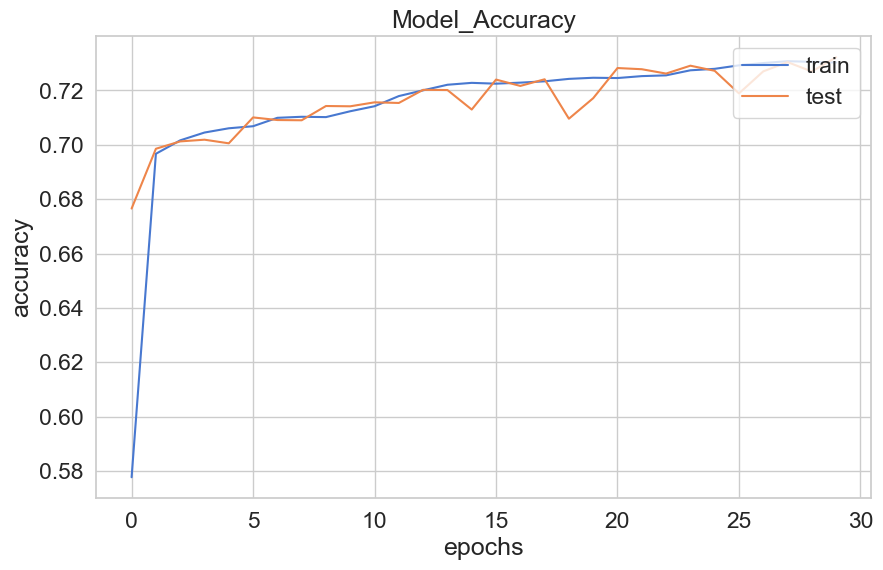

In [28]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model_Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper right')

In [29]:
predictions=autoencoder.predict(xtest)

1781/1781 [==============================] - 5s 2ms/step


In [30]:
mse=np.mean(np.power(xtest-predictions,2),axis=1)
error_df=pd.DataFrame({'Reconstruction_error':mse,'true_class':ytest})

In [31]:
error_df

,Reconstruction_error,true_class
43428,82.084345,1
49906,0.851807,0
29474,0.303746,0
276481,0.334885,0
278846,0.153012,0
...,...,...
75723,0.791835,0
252263,0.197365,0
221246,0.560019,0
81910,0.117374,0


In [32]:
error_df.describe()

,Reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.733610,0.001720
std,3.431407,0.041443
min,0.048375,0.000000
25%,0.239011,0.000000
50%,0.383871,0.000000
75%,0.609810,0.000000
max,260.951849,1.000000


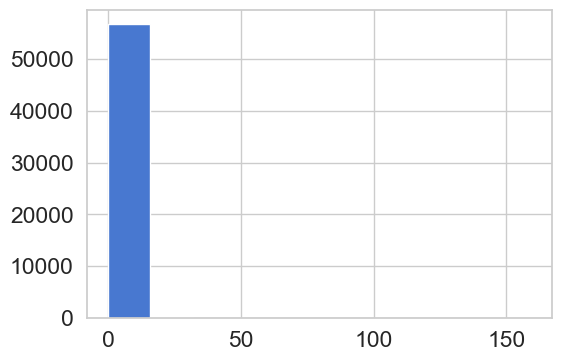

In [37]:
# Reconstruction error without fraud

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
normal_error_df = error_df[error_df['true_class'] == 0]
_ = ax.hist(normal_error_df['Reconstruction_error'].values, bins=10)

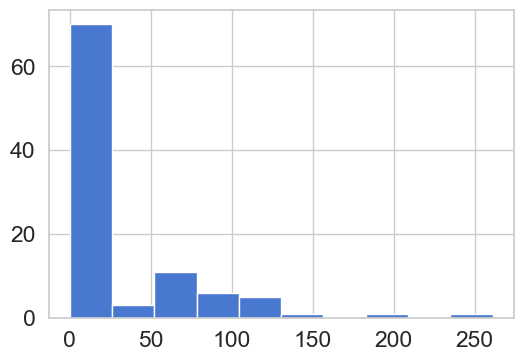

In [38]:
# Reconstruction error with fraud

fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
fraud_error_df=error_df[(error_df['true_class']==1)]
_=ax.hist(fraud_error_df.Reconstruction_error.values,bins=10)

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import precision_recall_curve,auc,roc_curve,recall_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

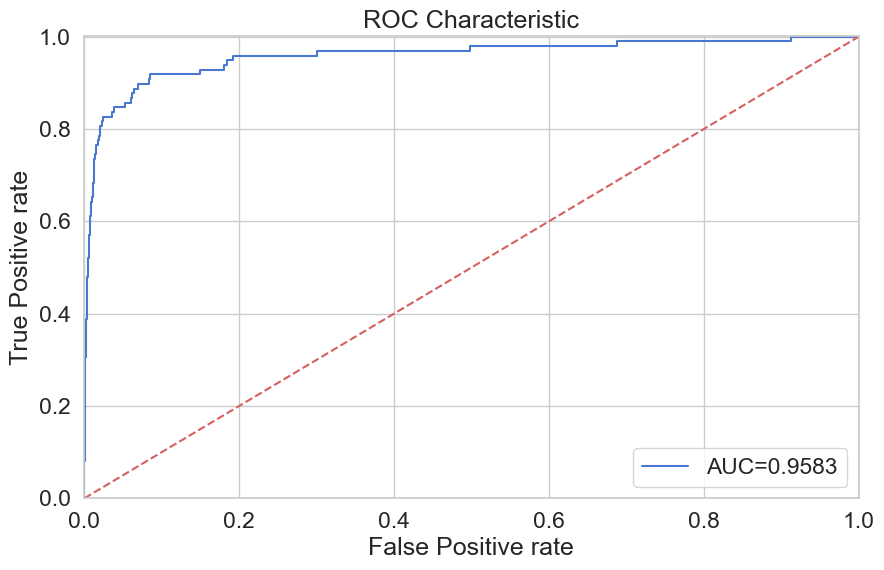

In [40]:
# ROC

fpr,tpr,thresholds=roc_curve(error_df.true_class,error_df.Reconstruction_error)
roc_auc=auc(fpr,tpr)
plt.title('ROC Characteristic')
plt.plot(fpr,tpr,label='AUC=%0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()

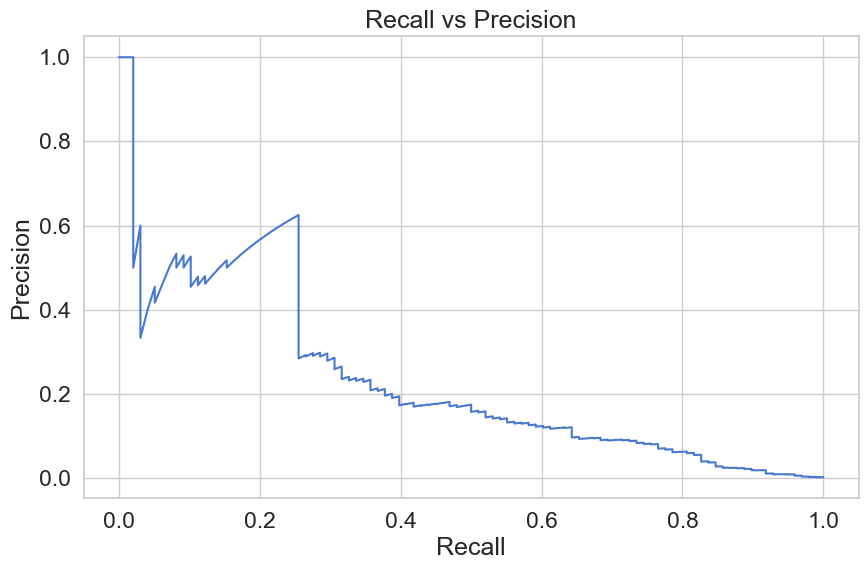

In [42]:
# Recall vs Precision

precision, recall, th = precision_recall_curve(error_df['true_class'], error_df['Reconstruction_error'])
plt.plot(recall, precision, 'b', label='precision-recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

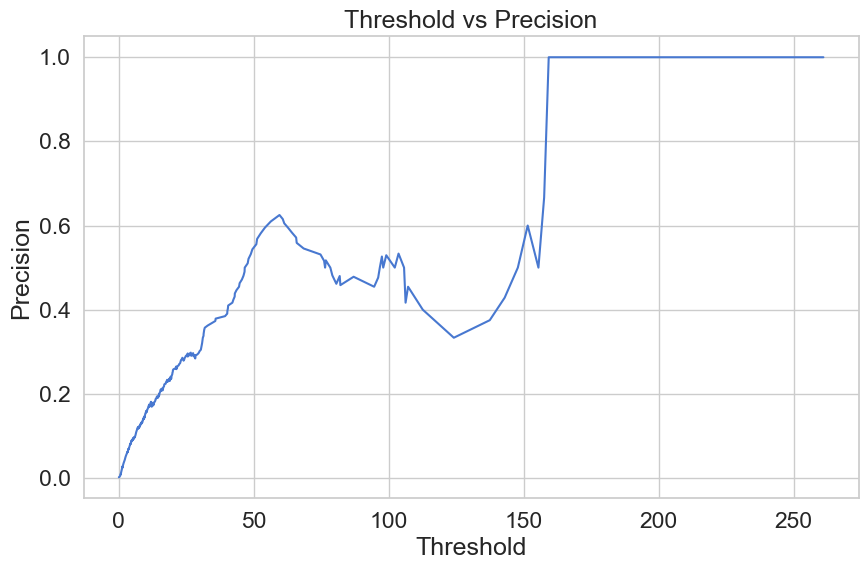

In [44]:
# Precision vs Threshold

precision, recall, th = precision_recall_curve(error_df['true_class'], error_df['Reconstruction_error'])
plt.plot(th, precision[1:], 'b', label='Threshold-precision curve')
plt.title('Threshold vs Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

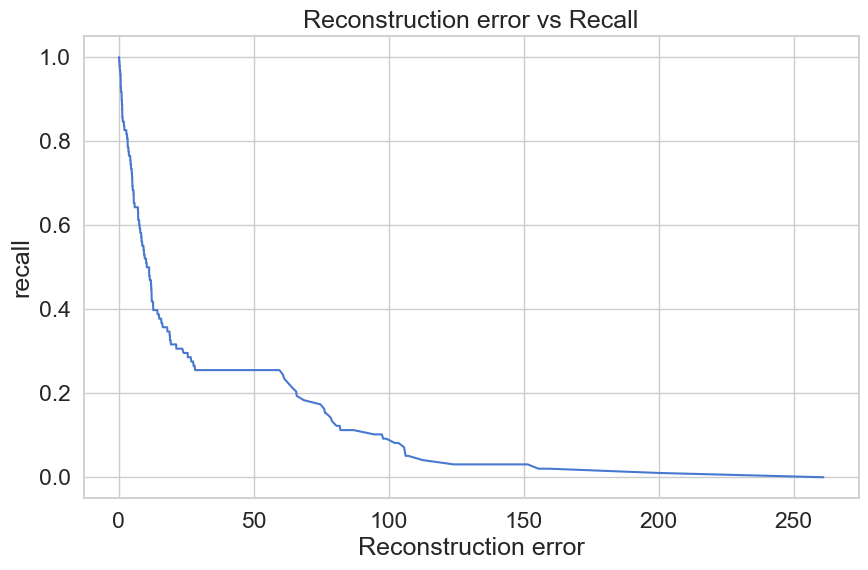

In [45]:
# Reconstruction_error vs Recall

plt.plot(th,recall[1:],'b',label='Threshold-recall curve')
plt.title('Reconstruction error vs Recall')
plt.xlabel('Reconstruction error')
plt.ylabel('recall')
plt.show()

In [46]:
# Prediction

threshold=2.9

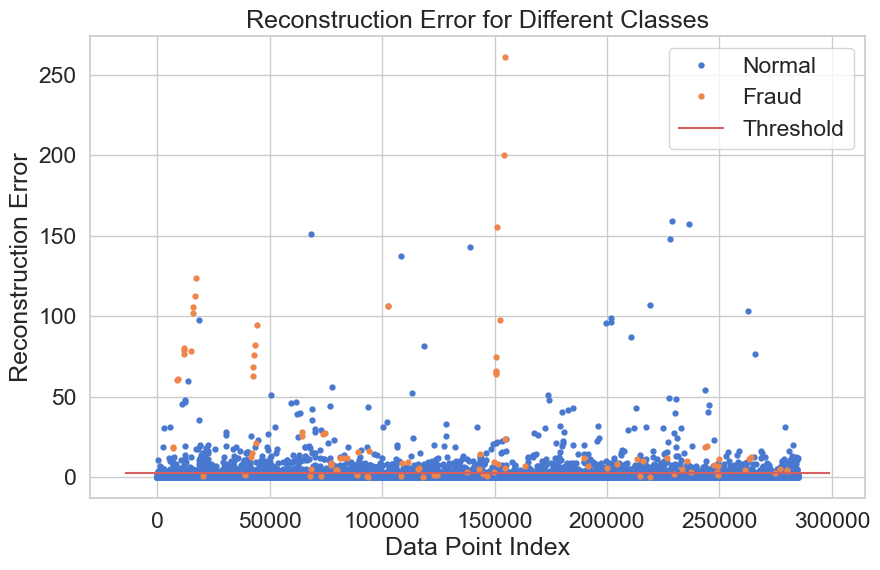

In [48]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group['Reconstruction_error'], marker='o', ms=3.5, linestyle='', label='Fraud' if name == 1 else 'Normal')

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')

ax.legend()
plt.title('Reconstruction Error for Different Classes')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.show()


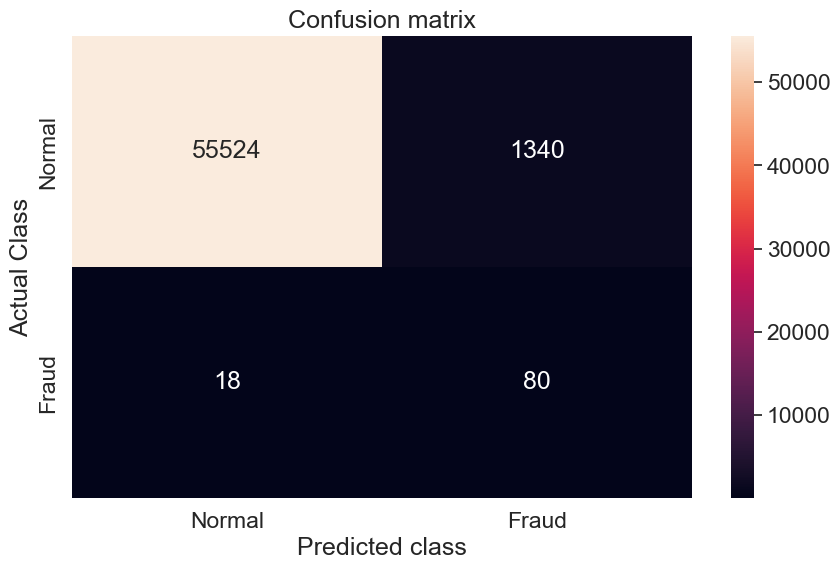

In [49]:
# Confusion Matrix

ypred=[1 if e>threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix=confusion_matrix(error_df.true_class,ypred)

sns.heatmap(conf_matrix,annot=True,xticklabels=LABELS,yticklabels=LABELS,fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual Class')
plt.show()